In [ ]:
# Testing if tensorflow is using GPU
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [ ]:
# Installing libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152
#from tensorflow.keras.classification_models.resnet import ResNet18
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
from sklearn.metrics import confusion_matrix
import json

# Location of the dataset in your Google Drive
dir = '/content/drive/My Drive/CognitiveEdge'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read Dataset
data = pd.read_csv(dir+'/6-features-34k-rows.csv')
data_df = pd.DataFrame(data)

In [ ]:
# Sample of dataset
data_df.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate,class
0,45,3,38823,43269,0.000002,0.000075,TELNET
1,46,4,21859,40481,0.000050,0.002300,FTP
2,226,207,17430,28950,0.000002,0.000461,HTTP
3,225,248,40103,61819,0.000026,0.005958,localForwarding
4,8222,7849,9423,23976,0.000106,0.873337,remoteForwarding


In [ ]:
# Changing class names to numerical values
class_name =data_df['class'].unique()
le = preprocessing.LabelEncoder()
le.fit(data_df['class'])
data_df['class']=le.transform(data_df['class'])
class_id = data_df['class'].unique()

In [ ]:
# Sample of dataset after changing class names 
data_df.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate,class
0,45,3,38823,43269,0.000002,0.000075,3
1,46,4,21859,40481,0.000050,0.002300,1
2,226,207,17430,28950,0.000002,0.000461,2
3,225,248,40103,61819,0.000026,0.005958,5
4,8222,7849,9423,23976,0.000106,0.873337,6


In [ ]:
# Making sure that all fields are integers
data_df['fpkt_rate'] = 1000000*data_df['fpkt_rate']
data_df['fbyte_rate'] = 1000000*data_df['fbyte_rate']
data_df.round(decimals=0)
data_df = data_df.astype(int)
data_df.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate,class
0,45,3,38823,43269,1,75,3
1,46,4,21859,40481,49,2299,1
2,226,207,17430,28950,2,460,2
3,225,248,40103,61819,26,5958,5
4,8222,7849,9423,23976,106,873336,6


In [ ]:
# Mapping class names and ids(numerical values)
class_dict={}
for i in range(0,len(class_name)):
    class_dict[int(class_id[i])]=class_name[i]

print(class_dict)

{3: 'TELNET', 1: 'FTP', 2: 'HTTP', 5: 'localForwarding', 6: 'remoteForwarding', 7: 'scp', 8: 'sftp', 10: 'x11', 9: 'shell', 0: 'DNS', 4: 'lime'}


In [ ]:
# Column information of dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34803 entries, 0 to 34802
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   mean_fpktl  34803 non-null  int64
 1   std_fpktl   34803 non-null  int64
 2   mean_fiat   34803 non-null  int64
 3   std_fiat    34803 non-null  int64
 4   fpkt_rate   34803 non-null  int64
 5   fbyte_rate  34803 non-null  int64
 6   class       34803 non-null  int64
dtypes: int64(7)
memory usage: 1.9 MB


In [ ]:
# Function to rotate arrray right by n value
def rotateRight(arr,n):
    return (arr[len(arr) - n:len(arr)] + arr[0:len(arr) - n])

In [ ]:
# Sample of how rotation works - Example of layered bitmap
arr = ['a','b','c','d','e','f']
print(rotateRight(arr,0))
print(rotateRight(arr,1))
print(rotateRight(arr,2))
print(rotateRight(arr,3))
print(rotateRight(arr,4))
print(rotateRight(arr,5))
print(rotateRight(arr,6))

['a', 'b', 'c', 'd', 'e', 'f']
['f', 'a', 'b', 'c', 'd', 'e']
['e', 'f', 'a', 'b', 'c', 'd']
['d', 'e', 'f', 'a', 'b', 'c']
['c', 'd', 'e', 'f', 'a', 'b']
['b', 'c', 'd', 'e', 'f', 'a']
['a', 'b', 'c', 'd', 'e', 'f']


In [ ]:
# Function to create layered bitmap and simple bitmap
def createBitmap_Layered(attrib_list):
    bit_arr = []
    for i in range(len(attrib_list)+1):
        #print(i)
        a_list = rotateRight(attrib_list,i)
        bit_str = ''
        for attrib in a_list:
            bit_str += '{0:032b}'.format(attrib)
        bit_list = []
        for c in bit_str:
            bit_list.append(int(c))
        bit_arr.append(bit_list)
    return bit_arr

def createBitmap_Single(attrib_list):
    bit_str = ''
    for attrib in attrib_list:
        bit_str += '{0:032b}'.format(attrib)
    bit_list = []
    for c in bit_str:
        bit_list.append(int(c))
    return bit_list

In [ ]:
# Functions to Create Simple and Layered Bitmap after converting them to numpy arrays with necessary padding
def createLayeredBitmap():
    #converting to bitmap
    row_list = []
    bitmaps = []
    bitmap_class = []
    for i in data_df.index:
        edict = {}
        attrib_list = [data_df['mean_fpktl'][i],data_df['std_fpktl'][i],data_df['mean_fiat'][i],data_df['std_fiat'][i],data_df['fpkt_rate'][i],data_df['fbyte_rate'][i]]
        bitmap = createBitmap_Layered(attrib_list)
        bitmap_np = np.array(bitmap)
        bitmaps.append(bitmap_np)
        #bitmap_np = bitmap_np.reshape(192,1) 
        bitmap_class.append(data_df['class'][i])

    bitmaps = np.array(bitmaps)
    bitmap_class = np.array(bitmap_class)
    #bitmaps = bitmaps.reshape(-1,1)
    #bitmaps = np.expand_dims(bitmaps,axis=2)
    bitmaps = np.expand_dims(bitmaps,axis=3)
    input_shape = (bitmaps.shape[1],bitmaps.shape[2],bitmaps.shape[3])
    return bitmaps,bitmap_class,input_shape

def createSimpleBitmap():
    #converting to bitmap
    row_list = []
    bitmaps = []
    bitmap_class = []
    for i in data_df.index:
        edict = {}
        attrib_list = [data_df['mean_fpktl'][i],data_df['std_fpktl'][i],data_df['mean_fiat'][i],data_df['std_fiat'][i],data_df['fpkt_rate'][i],data_df['fbyte_rate'][i]]
        bitmap = createBitmap_Single(attrib_list)
        bitmap_np = np.array(bitmap)
        bitmaps.append(bitmap_np)
        bitmap_np = bitmap_np.reshape(192,1) 
        bitmap_class.append(data_df['class'][i])

    bitmaps = np.array(bitmaps)
    bitmap_class = np.array(bitmap_class)
    #bitmaps = bitmaps.reshape(-1,1)
    bitmaps = np.expand_dims(bitmaps,axis=2)
    bitmaps = np.expand_dims(bitmaps,axis=3)
    input_shape = (bitmaps.shape[1],bitmaps.shape[2],bitmaps.shape[3])
    return bitmaps,bitmap_class,input_shape

In [ ]:
# Choose Layered Bitmap or Simple Bitmap Mode to continue training

#bitmaps,bitmap_class,input_shape = createLayeredBitmap()
bitmaps,bitmap_class,input_shape = createSimpleBitmap()
print(bitmaps.shape)
print(bitmap_class.shape)
print(input_shape)

(34803, 192, 1, 1)
(34803,)
(192, 1, 1)


In [ ]:
# Divide into train and test sets
X = bitmaps
y = np.ravel(bitmap_class)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
# Load Resnet Model (50,101,152)
print("[INFO] preparing model...")
baseModel = ResNet50(weights=None, include_top=False,
	input_tensor=Input(shape=input_shape))
# baseModel = ResNet101(weights=None, include_top=False,
# 	input_tensor=Input(shape=input_shape))
# baseModel = ResNet152(weights=None, include_top=False,
# 	input_tensor=Input(shape=input_shape))

[INFO] preparing model...


In [ ]:
# Adding Dense Layers at the end of resnet along with activation layer
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(11, activation="softmax")(headModel)

In [ ]:
# Define the neural network model
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# Model Summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 1, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 7, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 1, 64)    3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 1, 64)    256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Make all layers in model Trainable
for layer in baseModel.layers:
	layer.trainable = True

In [ ]:
# Compile the model with loss and optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Training Model
history = model.fit(X_train, y_train,epochs=15, batch_size=256, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
109/109 [==============================] - 46s 426ms/step - loss: 2.6629 - accuracy: 0.4582 - val_loss: 2.0745 - val_accuracy: 0.4359
Epoch 2/15
109/109 [==============================] - 42s 384ms/step - loss: 0.7516 - accuracy: 0.7179 - val_loss: 2.4510 - val_accuracy: 0.1014
Epoch 3/15
109/109 [==============================] - 42s 385ms/step - loss: 0.4720 - accuracy: 0.8370 - val_loss: 2.7903 - val_accuracy: 0.1014
Epoch 4/15
109/109 [==============================] - 42s 385ms/step - loss: 0.3730 - accuracy: 0.8657 - val_loss: 3.5044 - val_accuracy: 0.1014
Epoch 5/15
109/109 [==============================] - 42s 385ms/step - loss: 0.3149 - accuracy: 0.8898 - val_loss: 3.7445 - val_accuracy: 0.1049
Epoch 6/15
109/109 [==============================] - 42s 385ms/step - loss: 0.2616 - accuracy: 0.9079 - val_loss: 2.6062 - val_accuracy: 0.2978
Epoch 7/15
109/109 [==============================] - 42s 385ms/step - loss: 0.2396 - accuracy: 0.9152 - val_loss: 0.4409 - val_ac

<Figure size 432x288 with 0 Axes>

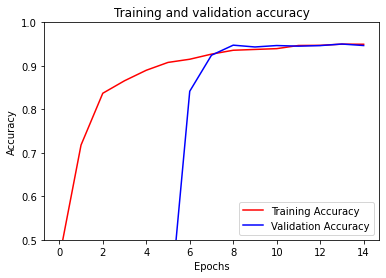

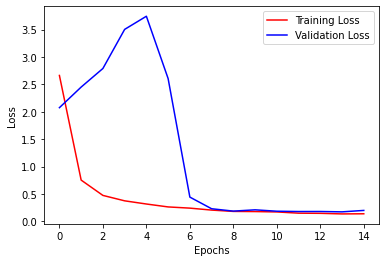

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting accuracy and loss

%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy",)
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim(0.5, 1.0)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim(0,0.5)
plt.legend(loc='upper right')
plt.figure()

In [ ]:
# Generating confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))
print(confusion_matrix(y_test, y_pred_bool))
print("\nMap to class id and class name: ")
print(json.dumps(class_dict, indent=4, sort_keys=True))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       263
           1       0.95      0.71      0.82        56
           2       0.83      0.87      0.85       706
           3       0.99      0.99      0.99       154
           4       0.97      0.97      0.97      3034
           5       0.99      0.92      0.96       519
           6       0.99      0.98      0.99       485
           7       0.88      0.92      0.90       484
           8       0.91      0.93      0.92       482
           9       0.94      0.91      0.92       392
          10       0.98      0.93      0.96       386

    accuracy                           0.95      6961
   macro avg       0.95      0.92      0.93      6961
weighted avg       0.95      0.95      0.95      6961

[[ 263    0    0    0    0    0    0    0    0    0    0]
 [   0   40    1    1   14    0    0    0    0    0    0]
 [   3    1  612    1   68    0    0    1    0   15    5]
 [   0    0  